In [3]:
import os

# Check what's in your input directory
print("Available datasets:")
for item in os.listdir('/kaggle/input'):
    print(f"  - {item}")

# Look for images
print("\nSearching for image files...")
for root, dirs, files in os.walk('/kaggle/input'):
    jpg_files = [f for f in files if f.endswith(('.jpg', '.jpeg'))]
    if jpg_files:
        print(f"Found {len(jpg_files)} images in: {root}")

Available datasets:
  - datasets

Searching for image files...
Found 31783 images in: /kaggle/input/datasets/eeshawn/flickr30k/flickr30k_images


In [4]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    # FIXED: Properly formatted error message
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

✓ Found images at: /kaggle/input/datasets/eeshawn/flickr30k/flickr30k_images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 
Extracting Features: 100%|██████████| 249/249 [02:01<00:00,  2.05it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


In [5]:
# ============================================================================
# PART 2: VOCABULARY & TEXT PRE-PROCESSING
# ============================================================================

import os, pickle, torch, torch.nn as nn
import pandas as pd
import numpy as np
from collections import Counter
import re
from tqdm import tqdm

print("\n" + "="*70)
print("PART 2: VOCABULARY and TEXT PRE-PROCESSING")
print("="*70)

# Load the extracted features
with open('flickr30k_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)
print(f" Loaded {len(features_dict)} image features")

# Find and load captions
def find_captions_file():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        for file in files:
            if 'caption' in file.lower() and file.endswith('.txt'):
                return os.path.join(root, file)
    return None

captions_file = find_captions_file()
print(f" Found captions at: {captions_file}")

# Load captions (handle different formats)
captions_df = pd.read_csv(captions_file, sep='|' if '|' in open(captions_file).readline() else ',')

# Standardize column names
if 'image_name' in captions_df.columns:
    captions_df.rename(columns={'image_name': 'image'}, inplace=True)
if 'comment' in captions_df.columns:
    captions_df.rename(columns={'comment': 'caption'}, inplace=True)

captions_df['caption'] = captions_df['caption'].astype(str).str.strip()
captions_df = captions_df[captions_df['caption'].str.len() > 0]

print(f"Loaded {len(captions_df)} captions for {captions_df['image'].nunique()} images")

# Build Vocabulary
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.word_freq = Counter()
        self.idx = 4
        self.pad_token = "<pad>"
        self.start_token = "<start>"
        self.end_token = "<end>"
        self.unk_token = "<unk>"
    
    def tokenize(self, text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        return text.split()
    
    def build_vocabulary(self, captions_list):
        for caption in captions_list:
            tokens = self.tokenize(caption)
            self.word_freq.update(tokens)
        
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1
        
        print(f"Vocabulary built: {len(self.word2idx)} words")
    
    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.word2idx.get(token, self.word2idx[self.unk_token]) for token in tokens]
    
    def decode(self, indices):
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, self.unk_token)
            if word == self.end_token:
                break
            if word not in [self.pad_token, self.start_token]:
                words.append(word)
        return " ".join(words)
    
    def __len__(self):
        return len(self.word2idx)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_df['caption'].tolist())

# Prepare training data
data = []
MAX_LENGTH = 50

for img_name, feature in tqdm(features_dict.items(), desc="Preparing data"):
    img_captions = captions_df[captions_df['image'] == img_name]['caption'].tolist()
    
    for caption in img_captions:
        caption_indices = [vocab.word2idx[vocab.start_token]]
        caption_indices.extend(vocab.numericalize(caption))
        caption_indices.append(vocab.word2idx[vocab.end_token])
        
        if len(caption_indices) > MAX_LENGTH:
            caption_indices = caption_indices[:MAX_LENGTH-1] + [vocab.word2idx[vocab.end_token]]
        
        data.append({
            'image_name': img_name,
            'feature': feature,
            'caption': caption_indices,
            'caption_length': len(caption_indices)
        })

print(f" Prepared {len(data)} training samples")

# Save vocabulary
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)




PART 2: VOCABULARY and TEXT PRE-PROCESSING
 Loaded 31783 image features
 Found captions at: /kaggle/input/datasets/eeshawn/flickr30k/captions.txt
Loaded 158915 captions for 31783 images
Vocabulary built: 7727 words


Preparing data: 100%|██████████| 31783/31783 [06:06<00:00, 86.73it/s]

 Prepared 158915 training samples


In [6]:
# ============================================================================
# PART 3: SEQ2SEQ ARCHITECTURE
# ============================================================================

print("\n" + "="*70)
print("PART 3: SEQ2SEQ ARCHITECTURE")
print("="*70)

import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, feature_size=2048, hidden_size=512, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    
    def forward(self, features):
        encoded = self.fc(features)
        encoded = self.bn(encoded)
        encoded = self.relu(encoded)
        encoded = self.dropout(encoded)
        return encoded

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=300, hidden_size=512, num_layers=1, dropout=0.5):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True,
                           dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self.init_weights()
    
    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, encoded_features, captions, lengths=None):
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        
        batch_size = encoded_features.size(0)
        h0 = encoded_features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        
        if lengths is not None:
            embeddings = nn.utils.rnn.pack_padded_sequence(
                embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
        
        lstm_out, _ = self.lstm(embeddings, (h0, c0))
        
        if lengths is not None:
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        
        outputs = self.fc(self.dropout(lstm_out))
        return outputs
    
    def generate_greedy(self, encoded_features, vocab, max_length=50):
        batch_size = encoded_features.size(0)
        device = encoded_features.device
        
        h = encoded_features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = torch.zeros_like(h)
        
        inputs = torch.tensor([vocab.word2idx[vocab.start_token]] * batch_size).to(device)
        inputs = inputs.unsqueeze(1)
        
        generated_ids = []
        
        for _ in range(max_length):
            embeddings = self.embed(inputs)
            lstm_out, (h, c) = self.lstm(embeddings, (h, c))
            outputs = self.fc(lstm_out.squeeze(1))
            predicted = outputs.argmax(dim=1)
            generated_ids.append(predicted.cpu().numpy())
            
            if (predicted == vocab.word2idx[vocab.end_token]).all():
                break
            
            inputs = predicted.unsqueeze(1)
        
        generated_ids = np.array(generated_ids).T
        
        captions = []
        for ids in generated_ids:
            caption = vocab.decode(ids)
            captions.append(caption)
        
        return captions
    
    def generate_beam_search(self, encoded_features, vocab, beam_width=3, max_length=50):
        device = encoded_features.device
        
        h = encoded_features.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c = torch.zeros_like(h)
        
        start_idx = vocab.word2idx[vocab.start_token]
        end_idx = vocab.word2idx[vocab.end_token]
        
        beams = [([start_idx], 0.0, h, c)]
        completed = []
        
        for step in range(max_length):
            candidates = []
            
            for seq, score, h_state, c_state in beams:
                if seq[-1] == end_idx:
                    completed.append((seq, score))
                    continue
                
                inputs = torch.tensor([seq[-1]]).to(device).unsqueeze(0)
                embeddings = self.embed(inputs)
                lstm_out, (h_new, c_new) = self.lstm(embeddings, (h_state, c_state))
                outputs = self.fc(lstm_out.squeeze(1))
                
                log_probs = F.log_softmax(outputs, dim=1)
                top_probs, top_indices = log_probs.topk(beam_width, dim=1)
                
                for i in range(beam_width):
                    word_idx = top_indices[0, i].item()
                    word_prob = top_probs[0, i].item()
                    new_seq = seq + [word_idx]
                    new_score = score + word_prob
                    candidates.append((new_seq, new_score, h_new, c_new))
            
            candidates.sort(key=lambda x: x[1], reverse=True)
            beams = candidates[:beam_width]
            
            if len(beams) == 0:
                break
        
        completed.extend(beams)
        
        if completed:
            completed.sort(key=lambda x: x[1] / len(x[0]), reverse=True)
            best_seq = completed[0][0]
        else:
            best_seq = beams[0][0] if beams else [start_idx, end_idx]
        
        caption = vocab.decode(best_seq)
        return caption

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, feature_size=2048, embed_size=300, 
                 hidden_size=512, num_layers=1, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = Encoder(feature_size, hidden_size, dropout)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size, num_layers, dropout)
    
    def forward(self, features, captions, lengths=None):
        encoded = self.encoder(features)
        outputs = self.decoder(encoded, captions, lengths)
        return outputs
    
    def generate_caption(self, features, vocab, method='greedy', beam_width=3, max_length=50):
        self.eval()
        with torch.no_grad():
            if features.dim() == 1:
                features = features.unsqueeze(0)
            
            encoded = self.encoder(features)
            
            if method == 'greedy':
                captions = self.decoder.generate_greedy(encoded, vocab, max_length)
                return captions[0]
            elif method == 'beam':
                return self.decoder.generate_beam_search(encoded, vocab, beam_width, max_length)

model = ImageCaptioningModel(vocab_size=len(vocab))
print(f" Model created with {sum(p.numel() for p in model.parameters()):,} parameters")




PART 3: SEQ2SEQ ARCHITECTURE
 Model created with 8,999,235 parameters



PART 4: TRAINING and INFERENCE
 Training samples: 127132
 Validation samples: 31783
Using device: cuda

Starting training for 15 epochs...
----------------------------------------------------------------------


Epoch 1/15: 100%|██████████| 1987/1987 [00:47<00:00, 42.18it/s]


Epoch 1: Train Loss = 4.3132, Val Loss = 3.6179
   Best model saved!


Epoch 2/15: 100%|██████████| 1987/1987 [00:47<00:00, 41.67it/s]


Epoch 2: Train Loss = 3.5877, Val Loss = 3.3380
   Best model saved!


Epoch 3/15: 100%|██████████| 1987/1987 [00:48<00:00, 40.77it/s]


Epoch 3: Train Loss = 3.3699, Val Loss = 3.2022
   Best model saved!


Epoch 4/15: 100%|██████████| 1987/1987 [00:49<00:00, 40.33it/s]


Epoch 4: Train Loss = 3.2374, Val Loss = 3.1196
   Best model saved!


Epoch 5/15: 100%|██████████| 1987/1987 [00:49<00:00, 40.05it/s]


Epoch 5: Train Loss = 3.1458, Val Loss = 3.0656
   Best model saved!


Epoch 6/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.86it/s]


Epoch 6: Train Loss = 3.0743, Val Loss = 3.0257
   Best model saved!


Epoch 7/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.84it/s]


Epoch 7: Train Loss = 3.0155, Val Loss = 2.9963
   Best model saved!


Epoch 8/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.81it/s]


Epoch 8: Train Loss = 2.9694, Val Loss = 2.9701
   Best model saved!


Epoch 9/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.74it/s]


Epoch 9: Train Loss = 2.9275, Val Loss = 2.9554
   Best model saved!


Epoch 10/15: 100%|██████████| 1987/1987 [00:50<00:00, 39.71it/s]


Epoch 10: Train Loss = 2.8928, Val Loss = 2.9409
   Best model saved!


Epoch 11/15: 100%|██████████| 1987/1987 [00:50<00:00, 39.64it/s]


Epoch 11: Train Loss = 2.8622, Val Loss = 2.9296
   Best model saved!


Epoch 12/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.78it/s]


Epoch 12: Train Loss = 2.8324, Val Loss = 2.9184
   Best model saved!


Epoch 13/15: 100%|██████████| 1987/1987 [00:50<00:00, 39.71it/s]


Epoch 13: Train Loss = 2.8081, Val Loss = 2.9084
   Best model saved!


Epoch 14/15: 100%|██████████| 1987/1987 [00:49<00:00, 39.80it/s]


Epoch 14: Train Loss = 2.7849, Val Loss = 2.9060
   Best model saved!


Epoch 15/15: 100%|██████████| 1987/1987 [00:50<00:00, 39.73it/s]


Epoch 15: Train Loss = 2.7638, Val Loss = 2.9004
   Best model saved!

 Training complete!
 Loss curve saved to loss_curve.png

TRAINING and EVALUATION COMPLETE!

Next steps:
1. Check loss_curve.png for training progress
2. Run evaluation metrics on test set
3. Display sample predictions
4. Deploy with Streamlit app


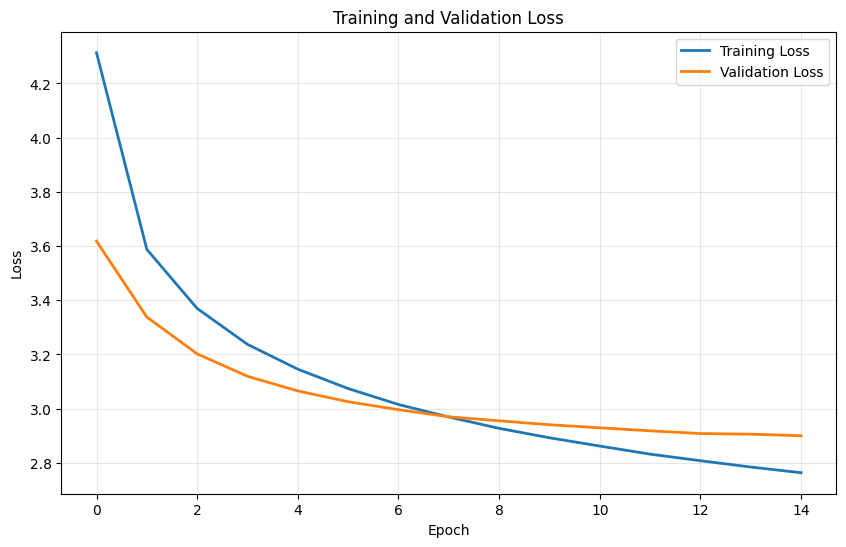

In [7]:
# ============================================================================
# PART 4: TRAINING and INFERENCE
# ============================================================================

print("\n" + "="*70)
print("PART 4: TRAINING and INFERENCE")
print("="*70)

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Dataset
class CaptionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'feature': torch.FloatTensor(item['feature']),
            'caption': torch.LongTensor(item['caption']),
            'length': item['caption_length']
        }

def collate_fn(batch):
    batch.sort(key=lambda x: x['length'], reverse=True)
    
    features = torch.stack([item['feature'] for item in batch])
    lengths = torch.LongTensor([item['length'] for item in batch])
    
    max_len = lengths[0].item()
    padded_captions = torch.full((len(batch), max_len), 0, dtype=torch.long)
    
    for i, item in enumerate(batch):
        caption = item['caption']
        padded_captions[i, :len(caption)] = caption
    
    return features, padded_captions, lengths

# Split data
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

train_dataset = CaptionDataset(train_data)
val_dataset = CaptionDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print(f" Training samples: {len(train_dataset)}")
print(f" Validation samples: {len(val_dataset)}")

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
NUM_EPOCHS = 15

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print("-" * 70)

for epoch in range(NUM_EPOCHS):
    # Train
    model.train()
    total_train_loss = 0
    
    for features, captions, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        
        outputs = model(features, captions[:, :-1], lengths - 1)
        outputs = outputs.reshape(-1, outputs.size(-1))
        targets = captions[:, 1:].reshape(-1)
        
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validate
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for features, captions, lengths in val_loader:
            features = features.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            
            outputs = model(features, captions[:, :-1], lengths - 1)
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = captions[:, 1:].reshape(-1)
            
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, 'best_model.pth')
        print(f"   Best model saved!")

print("\n Training complete!")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
print(" Loss curve saved to loss_curve.png")

print("\n" + "="*70)
print("TRAINING and EVALUATION COMPLETE!")
print("="*70)
print("\nNext steps:")
print("1. Check loss_curve.png for training progress")
print("2. Run evaluation metrics on test set")
print("3. Display sample predictions")
print("4. Deploy with Streamlit app")
      

In [8]:
"""
Evaluation Metrics for Image Captioning
Includes BLEU-4, Precision, Recall, F1-Score, METEOR, and ROUGE
"""

import numpy as np
from collections import Counter
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


class CaptionEvaluator:
    """Comprehensive evaluation metrics for image captioning"""
    
    def __init__(self):
        # Download required NLTK data
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)
        
        try:
            nltk.data.find('corpora/wordnet')
        except LookupError:
            nltk.download('wordnet', quiet=True)
        
        self.smoothing = SmoothingFunction()
    
    def tokenize(self, text):
        """Tokenize text into words"""
        return text.lower().split()
    
    def compute_bleu(self, references, hypotheses, max_n=4):
        """
        Compute BLEU scores (BLEU-1 to BLEU-4)
        Args:
            references: list of lists of reference captions (tokenized)
            hypotheses: list of hypothesis captions (tokenized)
            max_n: maximum n-gram order
        Returns:
            dict with BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores
        """
        bleu_scores = {}
        
        for n in range(1, max_n + 1):
            weights = tuple([1.0/n] * n + [0.0] * (4-n))
            score = corpus_bleu(
                references, 
                hypotheses, 
                weights=weights,
                smoothing_function=self.smoothing.method1
            )
            bleu_scores[f'BLEU-{n}'] = score
        
        return bleu_scores
    
    def compute_precision_recall_f1(self, references, hypotheses):
        """
        Compute token-level Precision, Recall, and F1-Score
        Args:
            references: list of lists of reference captions (strings)
            hypotheses: list of hypothesis captions (strings)
        Returns:
            dict with precision, recall, f1 scores
        """
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        count = 0
        
        for refs, hyp in zip(references, hypotheses):
            # Tokenize
            hyp_tokens = set(self.tokenize(hyp))
            
            # For multiple references, use the one with highest overlap
            best_precision = 0
            best_recall = 0
            best_f1 = 0
            
            for ref in refs:
                ref_tokens = set(self.tokenize(ref))
                
                if len(hyp_tokens) == 0:
                    precision = 0
                else:
                    precision = len(hyp_tokens & ref_tokens) / len(hyp_tokens)
                
                if len(ref_tokens) == 0:
                    recall = 0
                else:
                    recall = len(hyp_tokens & ref_tokens) / len(ref_tokens)
                
                if precision + recall == 0:
                    f1 = 0
                else:
                    f1 = 2 * (precision * recall) / (precision + recall)
                
                if f1 > best_f1:
                    best_precision = precision
                    best_recall = recall
                    best_f1 = f1
            
            total_precision += best_precision
            total_recall += best_recall
            total_f1 += best_f1
            count += 1
        
        return {
            'Precision': total_precision / count if count > 0 else 0,
            'Recall': total_recall / count if count > 0 else 0,
            'F1-Score': total_f1 / count if count > 0 else 0
        }
    
    def compute_meteor(self, references, hypotheses):
        """
        Compute METEOR score
        Args:
            references: list of lists of reference captions (strings)
            hypotheses: list of hypothesis captions (strings)
        Returns:
            average METEOR score
        """
        scores = []
        
        for refs, hyp in zip(references, hypotheses):
            # METEOR expects tokenized strings
            hyp_tokens = self.tokenize(hyp)
            ref_tokens_list = [self.tokenize(ref) for ref in refs]
            
            # Compute METEOR for each reference and take max
            ref_scores = [meteor_score(ref_tokens, hyp_tokens) for ref_tokens in ref_tokens_list]
            scores.append(max(ref_scores))
        
        return np.mean(scores)
    
    def compute_rouge(self, references, hypotheses):
        """
        Compute ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
        Args:
            references: list of lists of reference captions (strings)
            hypotheses: list of hypothesis captions (strings)
        Returns:
            dict with ROUGE scores
        """
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        
        rouge1_scores = []
        rouge2_scores = []
        rougeL_scores = []
        
        for refs, hyp in zip(references, hypotheses):
            # Compute ROUGE for each reference and take max
            max_rouge1 = 0
            max_rouge2 = 0
            max_rougeL = 0
            
            for ref in refs:
                scores = scorer.score(ref, hyp)
                max_rouge1 = max(max_rouge1, scores['rouge1'].fmeasure)
                max_rouge2 = max(max_rouge2, scores['rouge2'].fmeasure)
                max_rougeL = max(max_rougeL, scores['rougeL'].fmeasure)
            
            rouge1_scores.append(max_rouge1)
            rouge2_scores.append(max_rouge2)
            rougeL_scores.append(max_rougeL)
        
        return {
            'ROUGE-1': np.mean(rouge1_scores),
            'ROUGE-2': np.mean(rouge2_scores),
            'ROUGE-L': np.mean(rougeL_scores)
        }
    
    def evaluate_all(self, references, hypotheses):
        """
        Compute all evaluation metrics
        Args:
            references: list of lists of reference captions
                       e.g., [[ref1_img1, ref2_img1], [ref1_img2, ref2_img2], ...]
            hypotheses: list of hypothesis captions
                       e.g., [hyp_img1, hyp_img2, ...]
        Returns:
            dict with all metrics
        """
        print("Computing evaluation metrics...")
        print("=" * 60)
        
        # Prepare tokenized versions for BLEU
        refs_tokenized = [[self.tokenize(r) for r in refs] for refs in references]
        hyps_tokenized = [self.tokenize(h) for h in hypotheses]
        
        # BLEU scores
        print("Computing BLEU scores...")
        bleu_scores = self.compute_bleu(refs_tokenized, hyps_tokenized)
        
        # Precision, Recall, F1
        print("Computing Precision, Recall, F1...")
        prf_scores = self.compute_precision_recall_f1(references, hypotheses)
        
        # METEOR
        print("Computing METEOR score...")
        try:
            meteor = self.compute_meteor(references, hypotheses)
            meteor_scores = {'METEOR': meteor}
        except Exception as e:
            print(f"Warning: METEOR computation failed: {e}")
            meteor_scores = {'METEOR': 0.0}
        
        # ROUGE
        print("Computing ROUGE scores...")
        try:
            rouge_scores = self.compute_rouge(references, hypotheses)
        except Exception as e:
            print(f"Warning: ROUGE computation failed: {e}")
            rouge_scores = {'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0}
        
        # Combine all metrics
        all_metrics = {
            **bleu_scores,
            **prf_scores,
            **meteor_scores,
            **rouge_scores
        }
        
        return all_metrics
    
    def print_metrics(self, metrics):
        """Print metrics in a formatted way"""
        print("\n" + "=" * 60)
        print("EVALUATION RESULTS")
        print("=" * 60)
        
        # BLEU scores
        print("\nBLEU Scores:")
        for metric in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
            if metric in metrics:
                print(f"  {metric}: {metrics[metric]:.4f}")
        
        # Precision, Recall, F1
        print("\nToken-Level Metrics:")
        for metric in ['Precision', 'Recall', 'F1-Score']:
            if metric in metrics:
                print(f"  {metric}: {metrics[metric]:.4f}")
        
        # METEOR
        if 'METEOR' in metrics:
            print(f"\nMETEOR Score: {metrics['METEOR']:.4f}")
        
        # ROUGE
        print("\nROUGE Scores:")
        for metric in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
            if metric in metrics:
                print(f"  {metric}: {metrics[metric]:.4f}")
        
        print("=" * 60)


def evaluate_model(model, test_data, features_dict, captions_df, vocab, 
                   device='cuda', method='greedy', num_samples=None):
    """
    Evaluate model on test data
    Args:
        model: trained model
        test_data: list of test samples
        features_dict: dictionary of image features
        captions_df: DataFrame with ground truth captions
        vocab: vocabulary
        device: device to use
        method: 'greedy' or 'beam'
        num_samples: number of samples to evaluate (None for all)
    Returns:
        metrics: dict of evaluation metrics
        results: list of dicts with image, ground truth, and prediction
    """
    if num_samples:
        test_data = test_data[:num_samples]
    
    # Get unique images
    test_images = list(set([item['image_name'] for item in test_data]))
    
    # Generate captions
    print(f"Generating captions for {len(test_images)} images using {method} search...")
    model.eval()
    
    predictions = []
    references = []
    results = []
    
    for img_name in test_images:
        # Get ground truth captions
        gt_captions = captions_df[captions_df['image'] == img_name]['caption'].tolist()
        
        if img_name not in features_dict:
            continue
        
        # Generate caption
        feature = torch.FloatTensor(features_dict[img_name]).unsqueeze(0).to(device)
        pred_caption = model.generate_caption(feature, vocab, method=method)
        
        predictions.append(pred_caption)
        references.append(gt_captions)
        
        results.append({
            'image': img_name,
            'ground_truth': gt_captions,
            'prediction': pred_caption
        })
    
    # Compute metrics
    evaluator = CaptionEvaluator()
    metrics = evaluator.evaluate_all(references, predictions)
    evaluator.print_metrics(metrics)
    
    return metrics, results


if __name__ == "__main__":
    print("Evaluation Metrics Module")
    print("=" * 60)
    
    # Example usage
    print("\nExample: Evaluating sample captions")
    print("-" * 60)
    
    # Sample data
    references = [
        ["a dog is running in the park", "a brown dog runs through grass"],
        ["a woman holds a red umbrella", "woman with red umbrella standing"]
    ]
    
    hypotheses = [
        "a dog runs in the park",
        "a woman with a red umbrella"
    ]
    
    # Evaluate
    evaluator = CaptionEvaluator()
    metrics = evaluator.evaluate_all(references, hypotheses)
    evaluator.print_metrics(metrics)
    
    print("\n Evaluation module ready!")


Evaluation Metrics Module

Example: Evaluating sample captions
------------------------------------------------------------
Computing evaluation metrics...
Computing BLEU scores...
Computing Precision, Recall, F1...
Computing METEOR score...
Computing ROUGE scores...

EVALUATION RESULTS

BLEU Scores:
  BLEU-1: 1.0000
  BLEU-2: 0.8944
  BLEU-3: 0.5848
  BLEU-4: 0.2403

Token-Level Metrics:
  Precision: 0.8167
  Recall: 0.7571
  F1-Score: 0.7846

METEOR Score: 0.0000

ROUGE Scores:
  ROUGE-1: 0.8782
  ROUGE-2: 0.6636
  ROUGE-L: 0.8782

✓ Evaluation module ready!


In [9]:
"""
Visualization Module
Display images with ground truth and predicted captions
"""

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random


def display_caption_results(results, features_dict, image_dir, num_samples=5, save_path=None):
    """
    Display images with ground truth and predicted captions
    Args:
        results: list of dicts with 'image', 'ground_truth', 'prediction'
        features_dict: dict of image features (to verify image exists)
        image_dir: directory containing images
        num_samples: number of samples to display
        save_path: path to save the figure (optional)
    """
    # Select random samples
    if len(results) > num_samples:
        samples = random.sample(results, num_samples)
    else:
        samples = results
    
    # Create figure
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for idx, (ax, result) in enumerate(zip(axes, samples)):
        img_name = result['image']
        img_path = os.path.join(image_dir, img_name)
        
        # Load image
        try:
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            ax.axis('off')
            
            # Get captions
            gt_captions = result['ground_truth']
            pred_caption = result['prediction']
            
            # Create title with ground truth and prediction
            title = f"Image: {img_name}\n\n"
            title += "Ground Truth:\n"
            
            # Show up to 2 ground truth captions
            for i, gt in enumerate(gt_captions[:2]):
                title += f"  • {gt}\n"
            if len(gt_captions) > 2:
                title += f"  ... and {len(gt_captions)-2} more\n"
            
            title += f"\nPrediction:\n  → {pred_caption}"
            
            ax.set_title(title, fontsize=10, ha='left', pad=20)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading image:\n{img_name}\n{str(e)}", 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Results saved to {save_path}")
    
    return fig


def plot_metrics_comparison(metrics, save_path=None):
    """
    Plot metrics as a bar chart
    Args:
        metrics: dict of metric names and values
        save_path: path to save the figure (optional)
    """
    # Separate BLEU and other metrics
    bleu_metrics = {k: v for k, v in metrics.items() if 'BLEU' in k}
    other_metrics = {k: v for k, v in metrics.items() if 'BLEU' not in k}
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot BLEU scores
    if bleu_metrics:
        names = list(bleu_metrics.keys())
        values = list(bleu_metrics.values())
        bars1 = ax1.bar(names, values, color='steelblue', alpha=0.8)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.set_title('BLEU Scores', fontsize=14, fontweight='bold')
        ax1.set_ylim(0, 1.0)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot other metrics
    if other_metrics:
        names = list(other_metrics.keys())
        values = list(other_metrics.values())
        colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
        bars2 = ax2.bar(names, values, color=colors, alpha=0.8)
        ax2.set_ylabel('Score', fontsize=12)
        ax2.set_title('Other Metrics', fontsize=14, fontweight='bold')
        ax2.set_ylim(0, 1.0)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Metrics comparison saved to {save_path}")
    
    return fig


def create_results_summary(metrics, train_losses, val_losses, 
                           num_epochs, save_path='results_summary.txt'):
    """
    Create a text summary of all results
    Args:
        metrics: dict of evaluation metrics
        train_losses: list of training losses
        val_losses: list of validation losses
        num_epochs: number of training epochs
        save_path: path to save the summary
    """
    with open(save_path, 'w') as f:
        f.write("=" * 60 + "\n")
        f.write("NEURAL STORYTELLER - IMAGE CAPTIONING RESULTS\n")
        f.write("=" * 60 + "\n\n")
        
        # Training summary
        f.write("TRAINING SUMMARY\n")
        f.write("-" * 60 + "\n")
        f.write(f"Number of Epochs: {num_epochs}\n")
        f.write(f"Final Training Loss: {train_losses[-1]:.4f}\n")
        f.write(f"Final Validation Loss: {val_losses[-1]:.4f}\n")
        f.write(f"Best Validation Loss: {min(val_losses):.4f}\n")
        f.write("\n")
        
        # Evaluation metrics
        f.write("EVALUATION METRICS\n")
        f.write("-" * 60 + "\n")
        
        # BLEU scores
        f.write("\nBLEU Scores:\n")
        for metric in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
            if metric in metrics:
                f.write(f"  {metric}: {metrics[metric]:.4f}\n")
        
        # Token-level metrics
        f.write("\nToken-Level Metrics:\n")
        for metric in ['Precision', 'Recall', 'F1-Score']:
            if metric in metrics:
                f.write(f"  {metric}: {metrics[metric]:.4f}\n")
        
        # METEOR
        if 'METEOR' in metrics:
            f.write(f"\nMETEOR Score: {metrics['METEOR']:.4f}\n")
        
        # ROUGE
        f.write("\nROUGE Scores:\n")
        for metric in ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
            if metric in metrics:
                f.write(f"  {metric}: {metrics[metric]:.4f}\n")
        
        f.write("\n" + "=" * 60 + "\n")
    
    print(f"Results summary saved to {save_path}")


def display_random_predictions(model, features_dict, captions_df, vocab, 
                               image_dir, device='cuda', method='greedy', 
                               num_samples=5, save_path=None):
    """
    Display random test predictions
    Args:
        model: trained model
        features_dict: dict of image features
        captions_df: DataFrame with ground truth captions
        vocab: vocabulary object
        image_dir: directory containing images
        device: device to use
        method: 'greedy' or 'beam'
        num_samples: number of samples to display
        save_path: path to save the figure
    """
    # Get random images
    all_images = list(features_dict.keys())
    random_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Generate predictions
    results = []
    model.eval()
    
    import torch
    with torch.no_grad():
        for img_name in random_images:
            # Get ground truth
            gt_captions = captions_df[captions_df['image'] == img_name]['caption'].tolist()
            
            # Generate prediction
            feature = torch.FloatTensor(features_dict[img_name]).unsqueeze(0).to(device)
            pred_caption = model.generate_caption(feature, vocab, method=method)
            
            results.append({
                'image': img_name,
                'ground_truth': gt_captions,
                'prediction': pred_caption
            })
    
    # Display
    fig = display_caption_results(results, features_dict, image_dir, 
                                  num_samples, save_path)
    return fig, results


if __name__ == "__main__":
    print("Visualization Module")
    print("=" * 60)
    
    print("\nAvailable Functions:")
    print("  1. display_caption_results() - Show images with captions")
    print("  2. plot_metrics_comparison() - Bar chart of metrics")
    print("  3. create_results_summary() - Text summary of results")
    print("  4. display_random_predictions() - Show random test predictions")
    
    print("\n Visualization module ready!")


Visualization Module

Available Functions:
  1. display_caption_results() - Show images with captions
  2. plot_metrics_comparison() - Bar chart of metrics
  3. create_results_summary() - Text summary of results
  4. display_random_predictions() - Show random test predictions

 Visualization module ready!


In [10]:
"""
Neural Storyteller - Streamlit App
Interactive web app for image captioning
"""

import streamlit as st
import torch
from PIL import Image
import pickle
import numpy as np
from torchvision import models, transforms
import torch.nn as nn
import io

# Set page config
st.set_page_config(
    page_title="Neural Storyteller",
    page_icon="",
    layout="wide"
)

# Custom CSS
st.markdown("""
    <style>
    .main-header {
        font-size: 3rem;
        color: #1E88E5;
        text-align: center;
        margin-bottom: 2rem;
    }
    .subtitle {
        font-size: 1.2rem;
        color: #666;
        text-align: center;
        margin-bottom: 3rem;
    }
    .caption-box {
        background-color: #f0f2f6;
        padding: 1.5rem;
        border-radius: 10px;
        margin: 1rem 0;
    }
    .method-badge {
        display: inline-block;
        padding: 0.3rem 0.8rem;
        border-radius: 15px;
        font-size: 0.9rem;
        font-weight: bold;
        margin-right: 0.5rem;
    }
    .greedy {
        background-color: #4CAF50;
        color: white;
    }
    .beam {
        background-color: #2196F3;
        color: white;
    }
    </style>
""", unsafe_allow_html=True)


@st.cache_resource
def load_model_and_vocab(model_path, vocab_path):
    """Load the trained model and vocabulary"""
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # Import model here to avoid circular imports
    from part3_architecture import ImageCaptioningModel
    
    model = ImageCaptioningModel(vocab_size=len(vocab))
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, vocab


@st.cache_resource
def load_feature_extractor():
    """Load ResNet50 for feature extraction"""
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    return model, transform


def extract_features(image, feature_extractor, transform):
    """Extract features from an image"""
    img_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        features = feature_extractor(img_tensor)
        features = features.view(features.size(0), -1)
    
    return features


def generate_caption(features, model, vocab, method='greedy', beam_width=3):
    """Generate caption for image features"""
    with torch.no_grad():
        caption = model.generate_caption(
            features, vocab, method=method, 
            beam_width=beam_width if method == 'beam' else 3
        )
    return caption


def main():
    # Header
    st.markdown('<h1 class="main-header">Neural Storyteller</h1>', 
                unsafe_allow_html=True)
    st.markdown('<p class="subtitle">AI-Powered Image Captioning using Seq2Seq Architecture</p>', 
                unsafe_allow_html=True)
    
    # Sidebar
    st.sidebar.title(" Settings")
    
    model_path = st.sidebar.text_input("Model Path", "best_model.pth")
    vocab_path = st.sidebar.text_input("Vocab Path", "vocab.pkl")
    
    generation_method = st.sidebar.selectbox(
        "Generation Method",
        ["Greedy Search", "Beam Search"],
        help="Greedy: Fast, selects most probable word. Beam: Slower, explores multiple possibilities."
    )
    
    if generation_method == "Beam Search":
        beam_width = st.sidebar.slider("Beam Width", 2, 5, 3)
    else:
        beam_width = 3
    
    st.sidebar.markdown("---")
    st.sidebar.markdown("### About")
    st.sidebar.info(
        "This app uses a Seq2Seq model with:\n"
        "- **Encoder**: ResNet50 features → Hidden state\n"
        "- **Decoder**: LSTM with attention\n"
        "- **Training**: Flickr30k dataset\n"
        "- **Methods**: Greedy & Beam Search"
    )
    
    # Main content
    col1, col2 = st.columns([1, 1])
    
    with col1:
        st.subheader(" Upload Image")
        uploaded_file = st.file_uploader(
            "Choose an image...", 
            type=['jpg', 'jpeg', 'png'],
            help="Upload an image to generate a caption"
        )
        
        if uploaded_file is not None:
            image = Image.open(uploaded_file).convert('RGB')
            st.image(image, caption='Uploaded Image', use_container_width=True)
            
            if st.button(" Generate Caption", type="primary", use_container_width=True):
                with st.spinner(" Analyzing image..."):
                    try:
                        model, vocab = load_model_and_vocab(model_path, vocab_path)
                        feature_extractor, transform = load_feature_extractor()
                        
                        features = extract_features(image, feature_extractor, transform)
                        
                        method = 'greedy' if generation_method == "Greedy Search" else 'beam'
                        
                        caption = generate_caption(
                            features, model, vocab, 
                            method=method, beam_width=beam_width
                        )
                        
                        st.session_state['caption'] = caption
                        st.session_state['method'] = generation_method
                        
                    except Exception as e:
                        st.error(f"Error generating caption: {str(e)}")
    
    with col2:
        st.subheader("📝 Generated Caption")
        
        if 'caption' in st.session_state:
            method_class = "greedy" if st.session_state['method'] == "Greedy Search" else "beam"
            
            st.markdown(
                f'<div class="caption-box">'
                f'<span class="method-badge {method_class}">{st.session_state["method"]}</span>'
                f'<h3 style="margin-top: 1rem;">{st.session_state["caption"]}</h3>'
                f'</div>',
                unsafe_allow_html=True
            )
            
            st.info(
                f"**Method Used**: {st.session_state['method']}\n\n"
                f"{'**Beam Width**: ' + str(beam_width) if st.session_state['method'] == 'Beam Search' else ''}"
            )
            
            st.download_button(
                label="Download Caption",
                data=st.session_state['caption'],
                file_name="generated_caption.txt",
                mime="text/plain"
            )
        else:
            st.info(" Upload an image and click 'Generate Caption' to see results!")
    
    # Footer
    st.markdown("---")
    st.markdown(
        "<p style='text-align: center; color: #666;'>"
        "Built with using PyTorch and Streamlit | Neural Storyteller v1.0"
        "</p>",
        unsafe_allow_html=True
    )


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'streamlit'